<a href="https://colab.research.google.com/github/akshaytoshniwal/akshaytoshniwal/blob/main/infosys_casestudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyxlsb import convert_date
import datetime as dt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [4]:
# !pip install pyxlsb
# !pip install nltk
ticket_df = pd.read_excel('infosys_casestudy.xlsb', engine='pyxlsb')

In [5]:
ticket_df.head()

,Ticket Number,Created Calendar Date,Submit Date,Month,Week,Year,Day,month_week,Last Resolved Date,Resolved Client Year WorkWeek,Resolved Client Year Month,Resolved Client Year Quarter,Escalated Agent Start Date,Resolved Agent Service Desk,Resolved Agent Team,Status Class,SLM Status,Short Description,APP BIC,Service Sub Type,Priority,Escalated Flag,Escalated Audit Date,Cancel Reason Description,CSAT (%),Knowledge Artical Number,Knowledge Title,Product Name,Service,Service Component,Contact Type,TAC Resolved,Country Name,Reopened,Reopened E2E,Region Code,TTR_Hours,TTR Less Than or Equal to 1 hr,TTR Less Than or Equal to 90 min,TTR Less Than or Equal to 30 min,CSAT,Agent Courtesy,Agent Skill,Service Quality,Service Timeliness,Easy To Use Service,Site Code,Support Skill,General Comment
0,INC010429794,43827,43827.702940,12. Dec,53,2019,Sun,5,43828.017870,202001,202001,202001,NaN,AMRTAC,PN,Closed,Within the Service Target,Microsoft Office 365 ProPlus : Outlook and Sky...,2-Business Critical,User Service Restoration,4 - Low,No,NaN,NaN,NaN,KB000640215,Workaround: Office 365 ProPlus installation is...,Microsoft Office 365 ProPlus,End-User Computing and Communications,Office Productivity,phone,Yes,United States,No,No,AMER,8.137222,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,INC010430302,43828,43828.021285,12. Dec,53,2019,Sun,5,43828.031262,202001,202001,202001,NaN,AMRTAC,PN,Closed,Within the Service Target,Circuit Employee Portal - User wants Circuit E...,1-Mission Critical,How Do I,4 - Low,No,NaN,NaN,NaN,KB000648656,Login Issue with circuit,Circuit Employee Portal,Hire to Retire,HR Engagement and Experience,phone,Yes,United States,No,No,AMER,0.990000,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RITM8217581,43828,43828.036933,12. Dec,53,2019,Sun,5,43828.039074,202001,202001,202001,NaN,AMRTAC,PN,Cancelled,Within the Service Target,TAC Unsupport Requests,NaN,catalog,4 - Low,No,NaN,NaN,NaN,NaN,NaN,NaN,Enterprise Service Solutions,Service Desk,phone,Yes,NaN,No,No,NaN,0.051388,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RITM8217584,43828,43828.038588,12. Dec,53,2019,Sun,5,43828.044954,202001,202001,202001,NaN,AMRTAC,PN,Cancelled,NaN,CORP Worker and System Account Admin PWD and U...,NaN,catalog,4 - Low,No,NaN,NaN,NaN,NaN,NaN,NaN,Digital Identity and Access Management,Digital Identity Access Crypto Mgmt,phone,Yes,NaN,No,No,NaN,0.152777,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,INC010428398,43826,43826.978426,12. Dec,53,2019,Sun,5,43828.053681,202001,202001,202001,43577.0,AMRTAC,PN,Cancelled,Within the Service Target,retical move : getting server error,2-Business Critical,User Service Restoration,4 - Low,Yes,43826.978426,No Response,NaN,NaN,NaN,CLS40R-AMHS,Mfg Automated Material Handling Systems,Mfg AMHS Storage,phone,No,United States,No,No,AMER,26.086666,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
ticket_df.columns
ticket_df.describe()

,Week,Year,month_week,Resolved Client Year WorkWeek,Resolved Client Year Month,Resolved Client Year Quarter,Escalated Agent Start Date,Escalated Audit Date,CSAT (%),TTR_Hours,CSAT
count,146595.000000,146595.000000,146595.000000,146595.000000,146595.000000,146595.000000,25660.000000,25698.000000,12976.000000,146595.000000,10253.000000
mean,10.332535,2019.981336,3.105897,202009.362025,202002.630015,202001.262178,43413.609860,43884.678191,0.879354,69.267256,4.555935
std,7.704993,0.135335,1.306742,5.106162,1.186328,0.439820,364.582105,39.812614,0.325580,448.439792,0.958217
min,1.000000,2019.000000,1.000000,202001.000000,202001.000000,202001.000000,35829.000000,43467.195856,0.000000,-16.700277,1.000000
25%,5.000000,2020.000000,2.000000,202005.000000,202002.000000,202001.000000,43270.000000,43855.970712,1.000000,0.300555,5.000000
50%,10.000000,2020.000000,3.000000,202009.000000,202003.000000,202001.000000,43577.000000,43886.441100,1.000000,0.961944,5.000000
75%,14.000000,2020.000000,4.000000,202014.000000,202004.000000,202002.000000,43653.000000,43916.394375,1.000000,15.845833,5.000000
max,53.000000,2020.000000,5.000000,202018.000000,202005.000000,202002.000000,43894.000000,43953.822141,1.000000,16765.861388,5.000000


In [7]:
ticket_df['Created Calendar Date'] = pd.TimedeltaIndex(ticket_df['Created Calendar Date'], unit='d') + dt.datetime(1899, 12, 30)

for i in range (len(ticket_df['Submit Date'])):
  # converted_submit_date.append(convert_date(ticket_df['Submit Date'][i]))
  ticket_df['Submit Date'][i] = convert_date(ticket_df['Submit Date'][i])

for i in range (len(ticket_df['Last Resolved Date'])):
  # converted_submit_date.append(convert_date(ticket_df['Submit Date'][i]))
  ticket_df['Last Resolved Date'][i] = convert_date(ticket_df['Last Resolved Date'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [8]:
updated_ticket_df = ticket_df[['Ticket Number', 'Created Calendar Date', 'Submit Date', 'Last Resolved Date', 'Short Description']]

In [9]:
updated_ticket_df.head()

,Ticket Number,Created Calendar Date,Submit Date,Last Resolved Date,Short Description
0,INC010429794,2019-12-28,2019-12-28 16:52:14,2019-12-29 00:25:44,Microsoft Office 365 ProPlus : Outlook and Sky...
1,INC010430302,2019-12-29,2019-12-29 00:30:38,2019-12-29 00:45:01,Circuit Employee Portal - User wants Circuit E...
2,RITM8217581,2019-12-29,2019-12-29 00:53:10,2019-12-29 00:56:16,TAC Unsupport Requests
3,RITM8217584,2019-12-29,2019-12-29 00:55:33,2019-12-29 01:04:44,CORP Worker and System Account Admin PWD and U...
4,INC010428398,2019-12-27,2019-12-27 23:28:55,2019-12-29 01:17:17,retical move : getting server error


In [10]:
tickets_created_per_day = updated_ticket_df['Created Calendar Date'].dt.date.value_counts()

In [11]:
tickets_created_per_day = tickets_created_per_day.to_frame()
tickets_created_per_day = tickets_created_per_day.reset_index()
tickets_created_per_day = tickets_created_per_day.rename(columns= {'index': 'date', 'Created Calendar Date': 'total_tickets_created'})

In [12]:
tickets_created_per_day

,date,total_tickets_created
0,2020-01-06,2066
1,2020-01-07,2023
2,2020-02-03,1940
3,2020-02-04,1871
4,2020-04-01,1848
...,...,...
371,2019-06-30,1
372,2019-09-07,1
373,2019-10-20,1
374,2019-05-27,1


   date  total_tickets_created
0  2018                      2
1  2019                   4934
2  2020                 141659


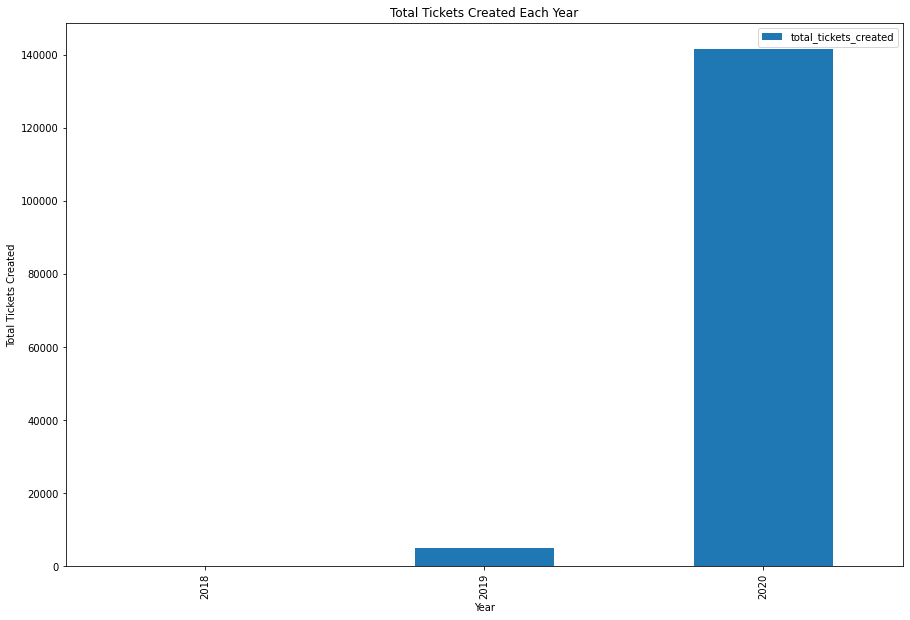

In [157]:
# tickets_created_per_day.plot.bar(x='date', y='total_tickets_created', width = 10 ,title='Total Tickets per Day Creation')
date_values = tickets_created_per_day['date'].sort_values(ascending=False)
date_values = date_values.sort_values(ascending=True)
# print(date_values)

tickets_created_per_day['date'] = pd.to_datetime(tickets_created_per_day['date'])
sorted_df = tickets_created_per_day.sort_values('date',ascending=True)

overall_data_distribution = sorted_df.groupby(sorted_df['date'].dt.year).sum()
overall_data_distribution = overall_data_distribution.reset_index()


print(overall_data_distribution)
overall_data_distribution.plot.bar(x='date', y='total_tickets_created',rot=90, figsize=(15, 10), xlabel='Year', ylabel='Total Tickets Created', title='Total Tickets Created Each Year')

In [36]:
updated_ticket_df['Short Description']

0         Microsoft Office 365 ProPlus : Outlook and Sky...
1         Circuit Employee Portal - User wants Circuit E...
2                                    TAC Unsupport Requests
3         CORP Worker and System Account Admin PWD and U...
4                       retical move : getting server error
                                ...                        
146590           VPN : User having VPN disconnection issue.
146591                               TAC Unsupport Requests
146592    Microsoft Outlook 365 ProPlus:-I'm the owner o...
146593                              Winzip will not install
146594    IT Device Market:-PC Accessories delivery are ...
Name: Short Description, Length: 146595, dtype: object

['windows', ':', 'shows', 'reference', 'account', 'locked', ',', 'login', 'failed']


In [151]:
def sentiment_analyses(text_data):
  vds = SentimentIntensityAnalyzer()
  score_details = vds.polarity_scores(text_data)
  score_df = pd.DataFrame.from_dict(score_details, orient='index')
  negative_score = score_df[0]['neg']
  positive_score = score_df[0]['pos']
  neutral_score = score_df[0]['neu']
  compound_overall_score = score_df[0]['compound']
  return compound_overall_score

In [171]:
text_data = []
overall_polarity_score = []
sentiment_value = []

for i in range(0,len(updated_ticket_df['Short Description'])):
  text_data.append(updated_ticket_df['Short Description'][i])
  overall_polarity_score.append(sentiment_analyses(text_data[i]))
  if overall_polarity_score[i] > 0.05:
    sentiment_value.append('Positive')

  if overall_polarity_score[i] < -0.05:
    sentiment_value.append('Negative')

  if overall_polarity_score[i] > -0.05 and overall_polarity_score[i] < 0.05:
    sentiment_value.append('Neutral')

print(text_data)
overall_polarity_score
print(sentiment_value)

sentiment_dataframe = {'text':text_data, 'sentiment_of_text':sentiment_value}

pd.DataFrame(sentiment_dataframe)

# text_to_tokens_sentence = sent_tokenize(text1)
# text_to_tokens_word = word_tokenize(text1)
# print(text_to_tokens_word)

['Microsoft Office 365 ProPlus : Outlook and Skype showing disconnected asking for the password.', 'Circuit Employee Portal - User wants Circuit Employee Portal as home page in Chrome', 'TAC Unsupport Requests', 'CORP Worker and System Account Admin PWD and Unlock', 'retical move : getting server error', 'TAC Unsupport Requests', 'TAC Unsupport Requests', 'Microsoft Office 365 ProPlus : User want to Delete all the Rules in the Outlook', 'TAC Unsupport Requests', 'Enterprise Login Password Reset - Automated Process', 'Enterprise Login Password Reset - Automated Process', 'Enterprise Login Password Reset - Automated Process', 'windows : shows reference account locked, login failed', 'Microsoft Lync/Skype for Business: Skype Microphone Issues, unble to listening voice', 'Microsoft Outlook 365 ProPlus : Outlook slowness', 'TAC Unsupport Requests', 'Client SM - Client Software Market - I CANT DOWNLOAD DOTNET. SAYS INSATLLATION PATH IS WRONG', 'TAC Unsupport Requests', 'MNE managed Microsoft

,text,sentiment_of_text
0,Microsoft Office 365 ProPlus : Outlook and Sky...,Neutral
1,Circuit Employee Portal - User wants Circuit E...,Neutral
2,TAC Unsupport Requests,Neutral
3,CORP Worker and System Account Admin PWD and U...,Neutral
4,retical move : getting server error,Negative
5,TAC Unsupport Requests,Neutral
6,TAC Unsupport Requests,Neutral
7,Microsoft Office 365 ProPlus : User want to De...,Positive
8,TAC Unsupport Requests,Neutral
9,Enterprise Login Password Reset - Automated Pr...,Neutral


In [138]:

frequency_distribution = FreqDist(text_to_tokens_word)
print(frequency_distribution)
frequency_distribution.most_common()

<FreqDist with 9 samples and 9 outcomes>


[('windows', 1),
 (':', 1),
 ('shows', 1),
 ('reference', 1),
 ('account', 1),
 ('locked', 1),
 (',', 1),
 ('login', 1),
 ('failed', 1)]

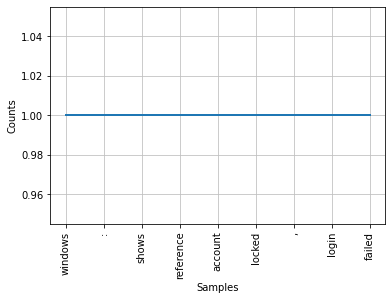

In [139]:
frequency_distribution.plot(15, cumulative=False)
plt.show()

In [141]:
stopwords_data = set(stopwords.words('english'))
print(stopwords_data)

{'did', 'each', 'myself', 'before', 'hasn', 'doesn', 'more', 'can', 'through', 'same', 'between', 'has', 'or', "wouldn't", 'themselves', 'but', 'this', 'shouldn', 'were', 'been', 'all', "isn't", 'some', 'herself', 'mustn', 'during', "you're", 'is', 'on', 'most', 'will', 'no', 've', 'needn', 'her', 't', 'being', 'over', 'to', 'ourselves', 'which', 'yourself', 'what', 'she', 'y', 'd', "haven't", 'when', 'how', 'have', 'yours', 'didn', "mightn't", 'won', 'don', 'again', "you'd", 'was', 'll', 'you', "doesn't", 'very', "mustn't", 'while', 'after', 'am', 'having', 'your', 'few', "she's", 'there', 're', 'once', 'those', 's', 'from', "needn't", 'are', 'wouldn', 'himself', "hadn't", 'with', 'theirs', 'both', 'for', 'such', 'them', 'other', 'ours', 'above', "that'll", 'that', 'where', 'do', 'hers', 'shan', 'at', 'against', 'off', 'they', 'just', 'mightn', 'my', 'does', 'up', 'weren', 'had', 'm', 'any', 'o', 'wasn', 'itself', 'out', "should've", 'the', 'an', 'into', "aren't", "hasn't", 'whom', 'd

In [142]:
updated_sentence = []
for word in text_to_tokens_word:
  if word not in stopwords_data:
    updated_sentence.append(word)

print(text_to_tokens_word)
print(updated_sentence)

['windows', ':', 'shows', 'reference', 'account', 'locked', ',', 'login', 'failed']
['windows', ':', 'shows', 'reference', 'account', 'locked', ',', 'login', 'failed']


In [143]:
ps = PorterStemmer()
lem = WordNetLemmatizer()

updated_stemmed_words = []
for words in updated_sentence:
  updated_stemmed_words.append(ps.stem(words))

updated_lematized_words = []
for words in updated_sentence:
  updated_lematized_words.append(lem.lemmatize(words,"v"))

print('Sentence after removing stop words: ', updated_sentence)
print('Sentence after performing stemming: ',updated_stemmed_words)
print('Sentence after performing lemmatization: ',updated_lematized_words)

Sentence after removing stop words:  ['windows', ':', 'shows', 'reference', 'account', 'locked', ',', 'login', 'failed']
Sentence after performing stemming:  ['window', ':', 'show', 'refer', 'account', 'lock', ',', 'login', 'fail']
Sentence after performing lemmatization:  ['windows', ':', 'show', 'reference', 'account', 'lock', ',', 'login', 'fail']


In [144]:
nltk.pos_tag(updated_lematized_words)

[('windows', 'NNS'),
 (':', ':'),
 ('show', 'NN'),
 ('reference', 'NN'),
 ('account', 'NN'),
 ('lock', 'NN'),
 (',', ','),
 ('login', 'JJ'),
 ('fail', 'NN')]

In [149]:
score_df

,0
neg,0.3550
neu,0.6450
pos,0.0000
compound,-0.5106
